In [1]:
import numpy as np
import pandas as pd
import glob

from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import collections

from scipy.stats import circmean
from scipy.stats import entropy

import scipy
import math

import librosa
import librosa.display

def doatoind(d):
    if (d<=-100):
        return(1)
    elif (d<=100):
        return(2)
    else:
        return(3)

def getMusic(time, doa):
    frame= int(time/DT)
    direction= int(((doa+180)%360)*72/360)
    return(music[frame][direction])

def func(x, o):
    if len(o)==0:
        return(False)
    elif max(o)>x:
        return(True)
    else:
        return(False)
    
def func_music(xd, xm, od, om):
#    print(xd, od)
    if len(od)<=1:
        return(False)
    elif max(od)>xd:
            return(True)
    else:
        sind= list(od).index(xd)
        lom= list(om)
        lom.pop(sind)
#        print(xm, lom)
        if max(lom)<xm:
            return(False)
        else:
            return(True)

from scipy import signal


In [2]:
f= "20190614-070001_separated.csv"
#f= "20190614-063001_separated.csv"
#f= "20190614-073002_separated.csv"
#f= "20190614-080002_separated.csv"

PAUSE_LENGTH= 0.8
PERIOD=10
DT= PERIOD/100.0

DT_VAD = 0.75 / 350

filelist= glob.glob("./*/separated.csv")
#filelist= glob.glob("./*_separated.csv")[:1]
datelist= [f[12:-22] for f in filelist]

import sys
import subprocess

In [7]:
#date="20190614-063001"
date="20190614-070001"
f= "./localized_{}_16k.wav/separated.csv".format(date)
print(f)
data= pd.read_csv(f, delimiter="\t")
data['time']=data['Time'].apply(lambda x: math.ceil(x/100.0*10)/10)
data.loc[:, ["Theta", "Phi"]] = data.loc[:, ["Theta", "Phi"]].applymap(lambda x: math.degrees(x))
dt= pd.to_datetime(date, format="%Y%m%d-%H%M%S")
data['datetime']= data['time'].apply(lambda x: dt+timedelta(seconds=x))
music = np.loadtxt("./localized_{}_16k.wav/spectrum.txt".format(date), delimiter="\t")
###########
groupdata= data.groupby("Sep")
templist=[]
for name, dat in groupdata:
    iid = name
    sid = name
    time = dat.iloc[0]["time"]
    duration = dat.iloc[-1]["time"] - time - PAUSE_LENGTH
    azimuth_list= dat["Phi"]
    azimuth_mean= circmean(azimuth_list, low= -180, high=180)
    power_list= dat["Power"]
    power_mean= np.average(power_list)
    power_base_list= dat["AvgPower"]
    power_base_mean= np.average(power_base_list)
    conf= power_mean/power_base_mean
        
    individual= doatoind(azimuth_mean)
    templist.append([name, dat.iloc[0]['datetime'], time, duration, azimuth_mean, power_mean, individual, conf, power_base_mean, azimuth_list])
sources= pd.DataFrame(templist, columns=['id', 'datetime', 'time', 'duration', 'azimuth_mean', 'power_mean', 'individual', 'conf', 'power_base', 'azimuth_list'])

./localized_20190614-070001_16k.wav/separated.csv


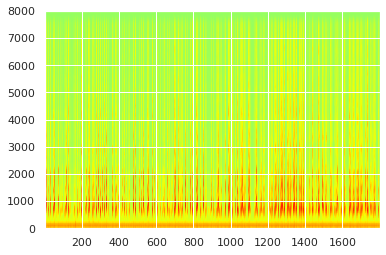

In [8]:
import scipy.io.wavfile as wio
Rate, Data = wio.read('/media/hd1/data_kod_hd1/localized_'+str(date)+'_16k.wav/remixed.wav')
totallength= len(Data)/Rate
d1= plt.specgram(Data, Fs=Rate, cmap="jet", interpolation="hermite")

power_spec_original= d1[0]
power_spec=np.log(d1[0]/np.max(d1[0]))



imagewidth= power_spec.shape[1]
fbin= int(power_spec.shape[0])
mx=-0.0
mn=-3.5
power_spec= np.array(power_spec)/(mx-mn)-mn/(mx-mn)


#powerspec_vocal= np.mean(power_spec_original[10:14], axis=0)
powerspec_vocal= np.max(power_spec[9:13], axis=0)
#powerspec_vocal= np.max(power_spec_original[9:13], axis=0)



In [9]:
sources_vad= np.load("./20200624_152128/"+str(date)+"_1ch.npy")
sources_vad= pd.DataFrame(sources_vad, columns=['begin', 'end', 'duration'])
sources_vad['time']= sources_vad['begin']*DT_VAD
sources_vad['duration']= sources_vad['duration']*DT_VAD
sources_vad['index'] = sources_vad.index

sources['vad']= sources.apply(lambda x: sources_vad[~((sources_vad['time']>(x['time']+x['duration'])) | (x['time']>sources_vad['time']+sources_vad['duration']))]['index'].values, axis=1)
sources['vad_count']=sources['vad'].apply(lambda x: len(x))

OFFSET= 0.3
sources['overlapped_duration']= sources.apply(lambda x: sources[~((sources['time']+OFFSET>(x['time']+x['duration'])) | (x['time']>sources['time']+sources['duration']-OFFSET))]['duration'].values, axis=1)
sources['overlapped_power']= sources.apply(lambda x: sources[~((sources['time']+OFFSET>(x['time']+x['duration'])) | (x['time']>sources['time']+sources['duration']-OFFSET))]['power_mean'].values, axis=1)

sources['removed']= sources.apply(lambda x: func(x['duration'], x['overlapped_duration']), axis=1)
#sources['removed']= sources.apply(lambda x: func(x['power_mean'], x['overlapped_power']), axis=1)

m= len(powerspec_vocal)/totallength
sources['duration_ori']=sources['duration'].copy()
sources['duration']=sources['duration'].apply(lambda x: x if x>0 else 0.2)
sources['vocal_max']= sources.apply(lambda x: np.max(powerspec_vocal[int(x['time']*m):int((x['time']+x['duration'])*m)]), axis=1)


sources_result= sources
sources_result.to_csv("./results/"+str(date)+"_result.csv")
    

In [10]:
############

from matplotlib.backends.backend_pdf import PdfPages
perpagesec=120
xlabelint= perpagesec/4
pp = PdfPages("./results/"+str(date)+"_multi3.pdf")

xranges= list(range(0, int(totallength), perpagesec))
#    print(list(xranges))
xranges.append(totallength)
xranges= np.array(xranges)
#    print(xranges)

for i in range(len(xranges)-1):
    fig= plt.figure(figsize=(11,4))

    ax1= plt.subplot(2,1,1)

    x=np.arange(0, totallength, xlabelint)
    plt.xticks(x*imagewidth/totallength, x)
    y=np.arange(0, 9000, 1000)

    print(xranges[i], xranges[i+1])        

    plt.imshow(power_spec, cmap="jet", extent=[0, totallength, 0, 8000], aspect="auto", vmin=mn, vmax=mx, interpolation="hermite", origin='lower')
#    plt.imshow(power_spec_original, cmap="jet", extent=[0, totallength, 0, 8000], aspect="auto", vmin=0, vmax=30, interpolation="hermite", origin='lower')

    plt.xlim(xranges[i], xranges[i+1])

    plt.xlabel("sec")
    plt.ylabel("Hz")
    plt.grid(False)
    
#    ax11=ax1.twinx()
#   ax11.plot(np.linspace(0, totallength, len(powerspec_vocal)), powerspec_vocal, color="white", linewidth=0.5)
#    ax11.set_ylim(-20, -10)

    colors=['red', 'green', 'yellow']

    #        for row in sources_result[sources_result['vad_count']>0].itertuples():
    #    for row in sources_result[(sources_result['vad_count']>0) & (sources_result['removed']==False)].itertuples():

    for row in sources_result[(sources_result['removed']==False) & (sources_result['vocal_max']>-2.5)].itertuples():
#    for row in sources_result[(sources_result['removed']==False)].itertuples():

            plt.plot([row.time, row.time+row.duration], [6000-row.individual*500, 6000-row.individual*500], c= colors[row.individual-1], linewidth=3)
            #plt.text(row.time+row.duration,850-row.cage*20-200, row.music_average, c= "white", size=10)
            plt.text(row.time+row.duration,6000-row.individual*500, "{0:.2f}".format(row.vocal_max), c= "white", size=5)

    for row in sources_result[sources_result['removed']==True].itertuples():
    #    for row in sources_result.itertuples():

        plt.plot([row.time, row.time+row.duration], [6000-row.individual*500, 6000-row.individual*500], c= [row.power_mean/30, row.power_mean/30, row.power_mean/30], linewidth=0.5)

    ax2= plt.subplot(2,1,2)
    plt.imshow(music.transpose(), cmap="jet", extent=[0, totallength, 180, -180], vmin=24, aspect="auto", interpolation="hermite")
    plt.xlim(xranges[i], xranges[i+1])
#    plt.ylim(-200,200)

    plt.xlabel("sec")
    plt.ylabel("Hz")
    plt.grid(False)
    plt.tight_layout()

    plt.savefig(pp, format="pdf", dpi=600)
    plt.close()
    fig.clf()
pp.close()


0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


In [170]:
power_spec

array([[-4.01856317, -2.84781078, -2.62152059, ..., -2.43999797,
        -2.46255582, -3.22960534],
       [-2.35137301, -2.39366742, -2.39291192, ..., -2.24530822,
        -2.31639605, -3.11481458],
       [-2.66871394, -2.97098816, -2.83430119, ..., -2.5601947 ,
        -2.74726716, -3.13322407],
       ...,
       [-5.57424211, -5.52801756, -5.88099986, ..., -5.62909715,
        -5.52283618, -6.09407835],
       [-5.40061017, -5.64988836, -5.60549756, ..., -5.76569011,
        -5.75293771, -5.77326783],
       [-5.6911458 , -5.52541754, -5.83928214, ..., -5.63658855,
        -6.35487805, -5.56372941]])

In [130]:
np.average(power_spec_original)

8.364748006535157

In [28]:
power_spec_original= d1[0]

In [143]:
meanamplitude=np.mean(power_spec_original[11:14], axis=0)

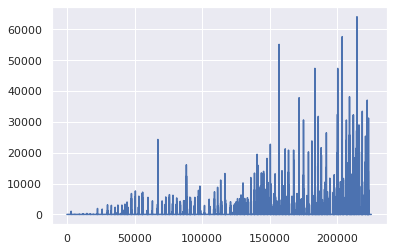

In [144]:
plt.plot(meanamplitude)

In [37]:
np.argmax(meanamplitude)*8000/129

682.1705426356589

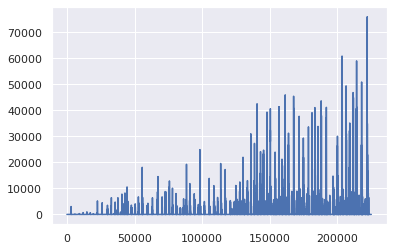

In [43]:
plt.plot(power_spec_original[11])

In [ ]:
plt.hist(np.log(power_spec_original[11]), bins=30)

(0, 10000)

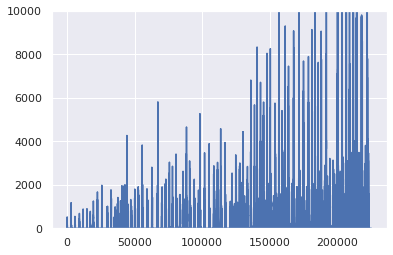

In [162]:
plt.plot(np.mean(power_spec_original[5:13], axis=0))
plt.ylim([0, 10000])

In [ ]:
PAUSE_LENGTH= 0.8
PERIOD=10
DT= PERIOD/100.0

DT_VAD = 0.75 / 350

filelist= glob.glob("./*/separated.csv")
#filelist= glob.glob("./*_separated.csv")[:1]
datelist= [f[12:-22] for f in filelist]

import sys
import subprocess

for date in datelist:
    f= "./localized_{}_16k.wav/separated.csv".format(date)
    print(f)

    data= pd.read_csv(f, delimiter="\t")
    data['time']=data['Time'].apply(lambda x: math.ceil(x/100.0*10)/10)
    data.loc[:, ["Theta", "Phi"]] = data.loc[:, ["Theta", "Phi"]].applymap(lambda x: math.degrees(x))
    dt= pd.to_datetime(date, format="%Y%m%d-%H%M%S")
    data['datetime']= data['time'].apply(lambda x: dt+timedelta(seconds=x))
    music = np.loadtxt("./localized_{}_16k.wav/spectrum.txt".format(date), delimiter="\t")
    ###########
    groupdata= data.groupby("Sep")
    templist=[]
    for name, dat in groupdata:
        iid = name
        sid = name
        time = dat.iloc[0]["time"]
        duration = dat.iloc[-1]["time"] - time - PAUSE_LENGTH
        azimuth_list= dat["Phi"]
        azimuth_mean= circmean(azimuth_list, low= -180, high=180)
        power_list= dat["Power"]
        power_mean= np.average(power_list)
        power_base_list= dat["AvgPower"]
        power_base_mean= np.average(power_base_list)
        conf= power_mean/power_base_mean

        individual= doatoind(azimuth_mean)
        templist.append([name, dat.iloc[0]['datetime'], time, duration, azimuth_mean, power_mean, individual, conf, power_base_mean, azimuth_list])
    sources= pd.DataFrame(templist, columns=['id', 'datetime', 'time', 'duration', 'azimuth_mean', 'power_mean', 'individual', 'conf', 'power_base', 'azimuth_list'])


    import scipy.io.wavfile as wio
    Rate, Data = wio.read('/media/hd1/data_kod_hd1/localized_'+str(date)+'_16k.wav/remixed.wav')
    totallength= len(Data)/Rate
    d1= plt.specgram(Data, Fs=Rate, cmap="jet", interpolation="hermite")

    power_spec_original= d1[0]
    power_spec=np.log(d1[0]/np.max(d1[0]))



    imagewidth= power_spec.shape[1]
    fbin= int(power_spec.shape[0])
    mx=-0.0
    mn=-3.5
    power_spec= np.array(power_spec)/(mx-mn)-mn/(mx-mn)


    #powerspec_vocal= np.mean(power_spec_original[10:14], axis=0)
    powerspec_vocal= np.max(power_spec[9:13], axis=0)
    #powerspec_vocal= np.max(power_spec_original[9:13], axis=0)

    sources_vad= np.load("./20200624_152128/"+str(date)+"_1ch.npy")
    sources_vad= pd.DataFrame(sources_vad, columns=['begin', 'end', 'duration'])
    sources_vad['time']= sources_vad['begin']*DT_VAD
    sources_vad['duration']= sources_vad['duration']*DT_VAD
    sources_vad['index'] = sources_vad.index

    sources['vad']= sources.apply(lambda x: sources_vad[~((sources_vad['time']>(x['time']+x['duration'])) | (x['time']>sources_vad['time']+sources_vad['duration']))]['index'].values, axis=1)
    sources['vad_count']=sources['vad'].apply(lambda x: len(x))

    OFFSET= 0.3
    sources['overlapped_duration']= sources.apply(lambda x: sources[~((sources['time']+OFFSET>(x['time']+x['duration'])) | (x['time']>sources['time']+sources['duration']-OFFSET))]['duration'].values, axis=1)
    sources['overlapped_power']= sources.apply(lambda x: sources[~((sources['time']+OFFSET>(x['time']+x['duration'])) | (x['time']>sources['time']+sources['duration']-OFFSET))]['power_mean'].values, axis=1)

    sources['removed']= sources.apply(lambda x: func(x['duration'], x['overlapped_duration']), axis=1)
    #sources['removed']= sources.apply(lambda x: func(x['power_mean'], x['overlapped_power']), axis=1)

    m= len(powerspec_vocal)/totallength
    sources['duration_ori']=sources['duration'].copy()
    sources['duration']=sources['duration'].apply(lambda x: x if x>0 else 0.2)
    
    sources['vocal_max']= sources.apply(lambda x: np.max(powerspec_vocal[int(x['time']*m):int((x['time']+x['duration'])*m)]), axis=1)


    sources_result= sources
    sources_result.to_csv("./results/"+str(date)+"_result.csv")   

    
    ###########

    from matplotlib.backends.backend_pdf import PdfPages
    perpagesec=120
    xlabelint= perpagesec/4
    pp = PdfPages("./results/"+str(date)+"_multi3.pdf")

    xranges= list(range(0, int(totallength), perpagesec))
    #    print(list(xranges))
    xranges.append(totallength)
    xranges= np.array(xranges)
    #    print(xranges)

    for i in range(len(xranges)-1):
        fig= plt.figure(figsize=(11,4))

        ax1= plt.subplot(2,1,1)

        x=np.arange(0, totallength, xlabelint)
        plt.xticks(x*imagewidth/totallength, x)
        y=np.arange(0, 9000, 1000)

        print(xranges[i], xranges[i+1])        

        plt.imshow(power_spec, cmap="jet", extent=[0, totallength, 0, 8000], aspect="auto", vmin=mn, vmax=mx, interpolation="hermite", origin='lower')
    #    plt.imshow(power_spec_original, cmap="jet", extent=[0, totallength, 0, 8000], aspect="auto", vmin=0, vmax=30, interpolation="hermite", origin='lower')

        plt.xlim(xranges[i], xranges[i+1])

        plt.xlabel("sec")
        plt.ylabel("Hz")
        plt.grid(False)

    #    ax11=ax1.twinx()
    #   ax11.plot(np.linspace(0, totallength, len(powerspec_vocal)), powerspec_vocal, color="white", linewidth=0.5)
    #    ax11.set_ylim(-20, -10)

        colors=['red', 'green', 'yellow']

        #        for row in sources_result[sources_result['vad_count']>0].itertuples():
        #    for row in sources_result[(sources_result['vad_count']>0) & (sources_result['removed']==False)].itertuples():

        for row in sources_result[(sources_result['removed']==False) & (sources_result['vocal_max']>-2.3)].itertuples():
    #    for row in sources_result[(sources_result['removed']==False)].itertuples():

                plt.plot([row.time, row.time+row.duration], [6000-row.individual*500, 6000-row.individual*500], c= colors[row.individual-1], linewidth=3)
                #plt.text(row.time+row.duration,850-row.cage*20-200, row.music_average, c= "white", size=10)
                plt.text(row.time+row.duration,6000-row.individual*500, "{0:.2f}".format(row.vocal_max), c= "white", size=5)

        for row in sources_result[sources_result['removed']==True].itertuples():
        #    for row in sources_result.itertuples():

            plt.plot([row.time, row.time+row.duration], [6000-row.individual*500, 6000-row.individual*500], c= [row.power_mean/30, row.power_mean/30, row.power_mean/30], linewidth=0.5)

        ax2= plt.subplot(2,1,2)
        plt.imshow(music.transpose(), cmap="jet", extent=[0, totallength, 180, -180], vmin=24, aspect="auto", interpolation="hermite")
        plt.xlim(xranges[i], xranges[i+1])
    #    plt.ylim(-200,200)

        plt.xlabel("sec")
        plt.ylabel("Hz")
        plt.grid(False)
        plt.tight_layout()

        plt.savefig(pp, format="pdf", dpi=600)
        plt.close()
        fig.clf()
    pp.close()

./localized_20191210-063001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191217-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191214-070002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190710-093002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191020-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191012-073001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191016-080002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190915-060001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191118-070002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191010-093002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190814-060002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190619-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191121-093002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191028-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191115-063001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190617-090003_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190708-090002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190718-093002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191023-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190711-090003_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190817-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190905-060002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190630-070002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190912-093003_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190925-093003_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190829-070001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191201-093002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190811-090002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190811-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191112-060001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0
1560.0 1680.0
1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190822-083003_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191105-070002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191110-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191222-080002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190910-090003_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191130-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190614-090002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190729-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191229-093003_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190924-070002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190929-063001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190720-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191214-090002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191203-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191226-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190910-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190918-080002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190919-080002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191014-060002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190929-090002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191226-063001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190721-060001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191008-093002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191103-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190823-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20200103-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191024-093002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190706-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190614-060001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191123-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191031-090002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190728-080002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190704-060001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190816-080002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191128-090003_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190805-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191119-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191121-090002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191117-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191215-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190719-060001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190711-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190711-070002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191125-070001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190816-060002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191127-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190806-080002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190719-090002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191125-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191001-080002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191011-060001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190814-083003_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191019-093002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191121-083002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191125-093002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191228-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190724-090002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190812-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191213-060001_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190818-073002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20190927-063002_16k.wav/separated.csv
0.0 120.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


120.0 240.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


240.0 360.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


360.0 480.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


480.0 600.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


600.0 720.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


720.0 840.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


840.0 960.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


960.0 1080.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1080.0 1200.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1200.0 1320.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1320.0 1440.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1440.0 1560.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1560.0 1680.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


1680.0 1800.0


/home/reiji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


./localized_20191220-073002_16k.wav/separated.csv


-3.6024367285011

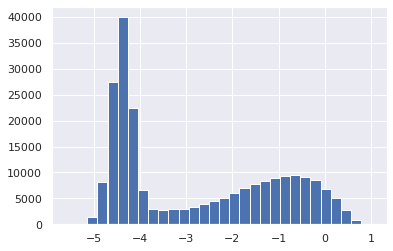

In [266]:
from scipy import signal
h= plt.hist(powerspec_vocal, bins=30)
hm=h[1][signal.argrelmin(h[0])[0][0]]
hm

In [253]:
np.argmin(h[1][5:10])

0

In [254]:
min(powerspec_vocal), max(powerspec_vocal)

(-5.4741322031867, -0.4301942159150052)

In [295]:
sources[sources['duration']<=0.4]

,id,datetime,time,duration,azimuth_mean,power_mean,individual,conf,power_base,azimuth_list,vad,vad_count,overlapped_duration,overlapped_power,removed
20,20,2019-10-16 08:05:44.100,342.1,0.4,0.000000,26.147800,2,1.125854,23.224851,346 0.0 347 0.0 348 0.0 349 0.0 35...,[],0,[0.3999999999999886],[26.147800000000004],False
21,21,2019-10-16 08:05:46.500,344.5,0.4,135.000000,26.201300,3,1.160836,22.571062,359 135.0 360 135.0 361 135.0 362 ...,[],0,[0.3999999999999886],[26.2013],False
129,129,2019-10-16 08:22:41.400,1359.4,0.4,-54.975127,26.094100,2,1.140544,22.878636,2717 -54.975127 2718 -54.975127 2719 -54...,[],0,[0.39999999999981806],[26.094100000000008],False
198,198,2019-10-16 08:30:01.500,1799.5,-0.5,-22.507464,26.626325,2,1.134636,23.466848,4664 -30.000728 4665 -19.992894 4666 -25...,[],0,[],[],False


In [297]:
sources

,id,datetime,time,duration,azimuth_mean,power_mean,individual,conf,power_base,azimuth_list,vad,vad_count,overlapped_duration,overlapped_power,removed,duration_bak,vocal_max
0,0,2019-10-16 08:01:29.300,87.3,0.6,-134.337708,26.063447,1,1.129154,23.082284,0 -125.024873 1 -135.000000 2 -135.00...,[],0,[0.6000000000000056],[26.06344666666667],False,0.6,-3.684678
1,1,2019-10-16 08:02:19.400,137.4,0.6,-116.355990,26.311427,1,1.161152,22.659754,15 -125.024873 16 -125.024873 17 -115.02...,[],0,[0.6000000000000056],[26.311426666666666],False,0.6,-3.767516
2,2,2019-10-16 08:02:24.200,142.2,0.7,-126.269217,26.370219,1,1.141295,23.105519,30 -135.000000 31 -130.010958 33 -130.01...,[],0,"[0.7, 0.4999999999999829]","[26.37021875, 26.105042857142866]",False,0.7,-3.631471
3,3,2019-10-16 08:02:24.300,142.3,0.5,139.989042,26.105043,3,1.129826,23.105367,32 139.989042 34 139.989042 36 139.98...,[],0,"[0.7, 0.4999999999999829]","[26.37021875, 26.105042857142866]",True,0.5,-3.631471
4,4,2019-10-16 08:02:31.700,149.7,0.4,-160.007106,26.094600,1,1.151782,22.655851,60 -160.007106 61 -160.007106 62 -160.00...,[],0,[0.400000000000017],[26.094600000000007],False,0.4,-3.641274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,194,2019-10-16 08:29:35.300,1773.3,2.5,3.237781,27.546397,2,1.177833,23.387361,4570 -4.992081 4571 -4.992081 4572 -4...,"[247, 248, 249]",3,"[2.4999999999999547, 0.40000000000004543]","[27.546397058823533, 26.3252]",False,2.5,0.449069
195,195,2019-10-16 08:29:36.600,1774.6,0.4,-135.000000,26.325200,1,1.123092,23.439927,4584 -135.0 4586 -135.0 4588 -135.0 4590...,[248],1,"[2.4999999999999547, 0.40000000000004543]","[27.546397058823533, 26.3252]",True,0.4,-0.074951
196,196,2019-10-16 08:29:48.400,1786.4,2.5,123.257191,26.853353,3,1.154531,23.259097,4617 135.000000 4618 130.010958 4619 ...,[],0,[2.4999999999999547],[26.853352941176468],False,2.5,-3.469847
197,197,2019-10-16 08:29:51.800,1789.8,0.4,115.027279,26.064900,3,1.142574,22.812443,4651 115.027279 4652 115.027279 4653 ...,[],0,[0.40000000000004543],[26.064900000000005],False,0.4,-3.732763


In [16]:
import glob

filelist= glob.glob("./*/separated.csv")
#filelist= glob.glob("./*_separated.csv")[:1]
datelist= [f[12:-22] for f in filelist]

print(len(filelist))

import sys
import subprocess

c=0
for f in datelist[:]:
    print(c, f)    
    subprocess.run(["python", "./process3.py", str(f)])
    c+=1

1623
0 20191210-063001
1 20191217-083002
2 20191214-070002
3 20190710-093002
4 20191020-073002
5 20191012-073001
6 20191016-080002
7 20190915-060001
8 20191118-070002
9 20191010-093002
10 20190814-060002
11 20190619-083002
12 20191121-093002
13 20191028-073002
14 20191115-063001
15 20190617-090003
16 20190708-090002
17 20190718-093002
18 20191023-083002
19 20190711-090003
20 20190817-083002
21 20190905-060002
22 20190630-070002
23 20190912-093003
24 20190925-093003
25 20190829-070001
26 20191201-093002
27 20190811-090002
28 20190811-083002
29 20191112-060001
30 20190822-083003
31 20191105-070002
32 20191110-063002
33 20191222-080002
34 20190910-090003
35 20191130-083002
36 20190614-090002
37 20190729-073002
38 20191229-093003
39 20190924-070002
40 20190929-063001
41 20190720-083002
42 20191214-090002
43 20191203-063002
44 20191226-083002
45 20190910-063002
46 20190918-080002
47 20190919-080002
48 20191014-060002
49 20190929-090002
50 20191226-063001
51 20190721-060001
52 20191008-09300

In [18]:
import pandas as pd
filelist= glob.glob("./results/*_result.csv")
for f in filelist:
    print(f)
    df= pd.read_csv(f)
    df.to_csv("./results/all2.csv", mode='a', header=False)


./results/20191124-080002_result.csv
./results/20191001-073002_result.csv
./results/20191129-093003_result.csv
./results/20191029-093002_result.csv
./results/20191209-090002_result.csv
./results/20191208-093002_result.csv
./results/20190720-063002_result.csv
./results/20191013-093002_result.csv
./results/20191023-090002_result.csv
./results/20190630-060001_result.csv
./results/20191108-073002_result.csv
./results/20190809-080002_result.csv
./results/20190711-093003_result.csv
./results/20190920-073002_result.csv
./results/20190927-083002_result.csv
./results/20190827-080002_result.csv
./results/20191107-063002_result.csv
./results/20191105-073002_result.csv
./results/20191216-070002_result.csv
./results/20190806-060001_result.csv
./results/20200101-073002_result.csv
./results/20190908-073002_result.csv
./results/20190912-080002_result.csv
./results/20191201-070001_result.csv
./results/20190718-090002_result.csv
./results/20191118-083002_result.csv
./results/20191115-063001_result.csv
.